## Dogs vs. Cats Image Classification

- Project task: Build CNN models to distinguish dog and cat images

### I. Data Information

**[Data Source - Kaggle](https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/data)**

In [3]:
# Import Libraries
import os
import cv2
import pandas as pd
import numpy as np
import zipfile

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input 
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()
from keras.preprocessing import image as image_utils
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

from glob import glob
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### II. Prepare Data

In [5]:
# unzip datasets and upload into the input folder
!unzip /kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip -d /kaggle/working/
!unzip /kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip -d /kaggle/working/

# separate images into dog and cat folders by creating new directory and move to test and train path
!mkdir dog cat

!mv /kaggle/working/cat  /kaggle/working/train/
!mv /kaggle/working/dog  /kaggle/working/train/

# move dog and cat images into the cat and dog path 
!mv /kaggle/working/train/cat.*  /kaggle/working/train/cat/
!mv /kaggle/working/train/dog.*  /kaggle/working/train/dog/

# create test1 directory and move test images into test1
!mkdir test_

!mv /kaggle/working/test_ /kaggle/working/test/test_
!mv /kaggle/working/test/*.jpg /kaggle/working/test/test_/

Becuase the output of above code is too long and for better display, I removed the output and add a screenshot to show portion of it instead.

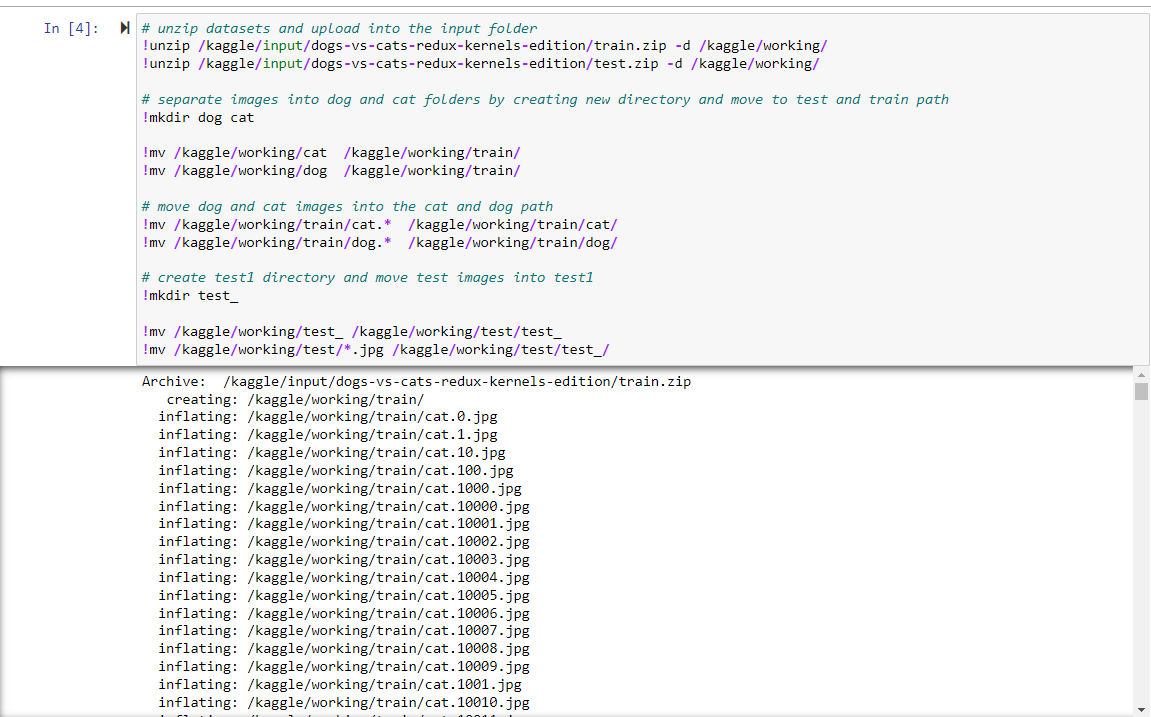

In [5]:
# check number of images in the train and test path
# train cat
!ls /kaggle/working/train/cat/ | wc -l

# train dog
!ls /kaggle/working/train/dog/ | wc -l

# test
!ls /kaggle/working/test/test_ | wc -l

12500
12500
12500


There are 12500 cat train images and 12500 dog train images.

There are also 12500 test images, but not labled with cat or dog 

#### Generate Image Data & do data augmentation

In [6]:
# resize image to 224 x 224
IMAGE_SIZE = [224,224]

epochs = 10

train_batch = 100
val_batch = 60
input_shape = (224, 224, 3)


# define train and test directory path
train_dir = '/kaggle/working/train/'
test_dir =  '/kaggle/working/test/'

DROPOUT_RATE = 0.2


In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True,
                                   validation_split=0.36)


train_set = train_datagen.flow_from_directory(train_dir, 
                                              batch_size = train_batch, 
                                              class_mode = 'binary', 
                                              target_size = (224, 224),
                                              color_mode = 'rgb',
                                              subset = 'training')

val_set = train_datagen.flow_from_directory(train_dir, 
                                            batch_size = val_batch, 
                                            class_mode = 'binary', 
                                            target_size = (224, 224),
                                            color_mode = 'rgb',
                                            subset = 'validation')

test_datagen = ImageDataGenerator(rescale = 1.0/255)

test_set = test_datagen.flow_from_directory(test_dir, 
                                            class_mode = None, 
                                            target_size = (224, 224),
                                            shuffle = False)



print(train_set.class_indices)

Found 16000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
{'cat': 0, 'dog': 1}


##  III. Model Exploration

I have tried:

**ResNet50V2**
   1. pretrained model ResNet50V2 and do transfer learning by changing the output layer (fix pretrained model layer)
   2. first fixed the pretrained model ResNet50v2, then train the model with not fixing the trained layer + customized output layer
   3. rebuild pretrained model ResNet50v2, not train model with not fixing trained layer, but adding batch normalization and dropout as well as customized output layer
     > optimizer tried: SGD and Adam (select Adam)
 

**VGG16**
   - rebuild pretrained model VGG by adding batch normalization and dropout
   - optimizer tried: Adam (select Adam)
    
After running above models, ResNet50 option 3 gives the best performance, so I chose it as my final model. with best score of 0.07248.

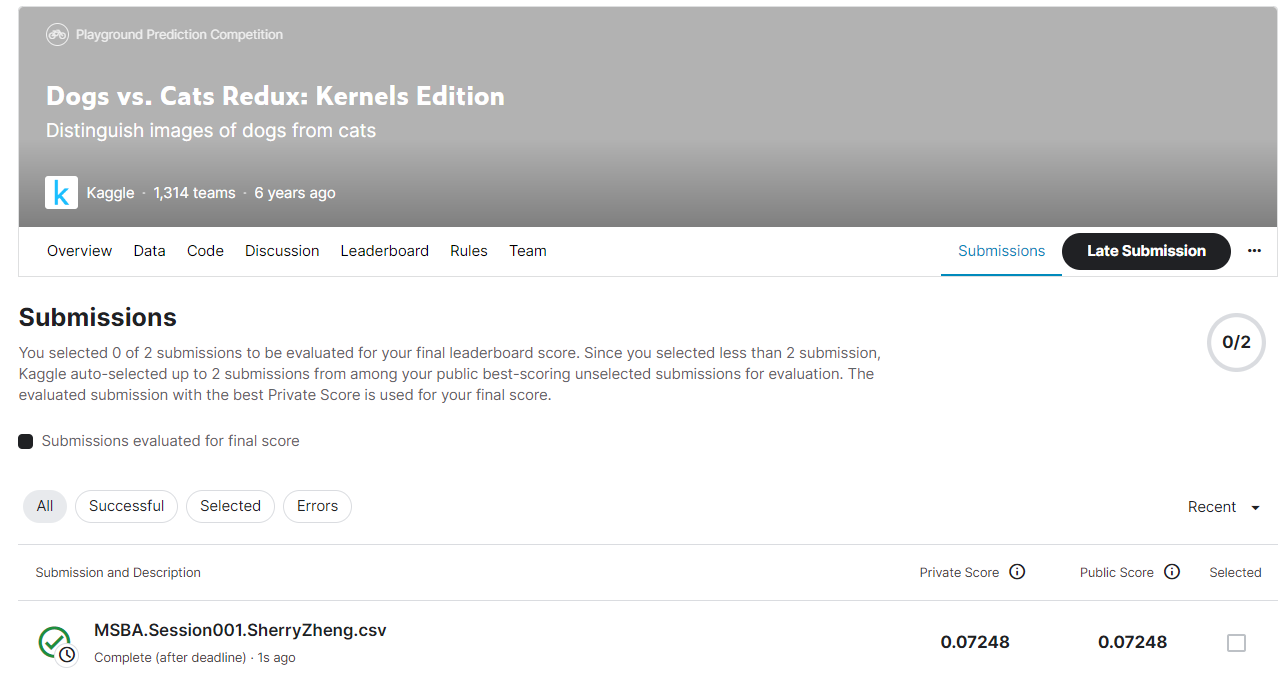

#### Set up Model


1. ResNet50

In [10]:
# customize own model structure by doing transfer learning with pretrained model: ResNet50V2
# 1. Instantiate a base model 
resnet = ResNet50V2(input_shape = input_shape, weights = 'imagenet',include_top = False)

# 2. Fix the pre-trained model layer and only modify the last layer
for layer in resnet.layers:
    layer.trainable = False
    
# rebuild the model with pre-trained model 
model1 = Sequential()
model1.add(base_model)
model1.add(layers.GlobalAveragePooling2D(name="avg"))
model1.add(layers.BatchNormalization())
model1.add(layers.Dropout(DROPOUT_RATE, name="dropout"))
model1.add(layers.Dense(1, activation = 'sigmoid'))

# avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
# output = keras.layers.Dense(1, activation = 'sigmoid')(avg)
# model = keras.models.Model(inputs=base_model.input, outputs = output)

In [11]:
# set up optimizer and what loss function to use
optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=0.01)
model1.compile(loss="binary_crossentropy", optimizer=optimizer, metrics = ["accuracy"])

# model training
history = model1.fit(train_set,
                   steps_per_epoch=int(0.75 * 16000 / train_batch),
                   validation_data=val_set,
                   validation_steps=int(0.15 * 9000 / val_batch),
                   epochs=10, callbacks=EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5))


2022-12-04 18:56:08.921480: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-12-04 18:56:15.238732: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


120/120 [==============================] - 195s 2s/step - loss: 0.1751 - accuracy: 0.9253 - val_loss: 0.1060 - val_accuracy: 0.9606
Epoch 2/10
120/120 [==============================] - 184s 2s/step - loss: 0.1039 - accuracy: 0.9582 - val_loss: 0.1040 - val_accuracy: 0.9591
Epoch 3/10
120/120 [==============================] - 182s 2s/step - loss: 0.0985 - accuracy: 0.9622 - val_loss: 0.0868 - val_accuracy: 0.9667
Epoch 4/10
120/120 [==============================] - 181s 2s/step - loss: 0.0911 - accuracy: 0.9629 - val_loss: 0.0983 - val_accuracy: 0.9659
Epoch 5/10
120/120 [==============================] - 181s 2s/step - loss: 0.0886 - accuracy: 0.9663 - val_loss: 0.0882 - val_accuracy: 0.9659
Epoch 6/10
120/120 [==============================] - 181s 2s/step - loss: 0.0856 - accuracy: 0.9658 - val_loss: 0.0684 - val_accuracy: 0.9742
Epoch 7/10
120/120 [==============================] - 181s 2s/step - loss: 0.0831 - accuracy: 0.9678 - val_loss: 0.0870 - val_accuracy: 0.9659
Epoch 8/10

In [12]:
# model summary
for index, layer in enumerate(model1.layers):
    print(index, layer.name)

0 resnet50v2
1 avg
2 batch_normalization_1
3 dropout
4 dense_1


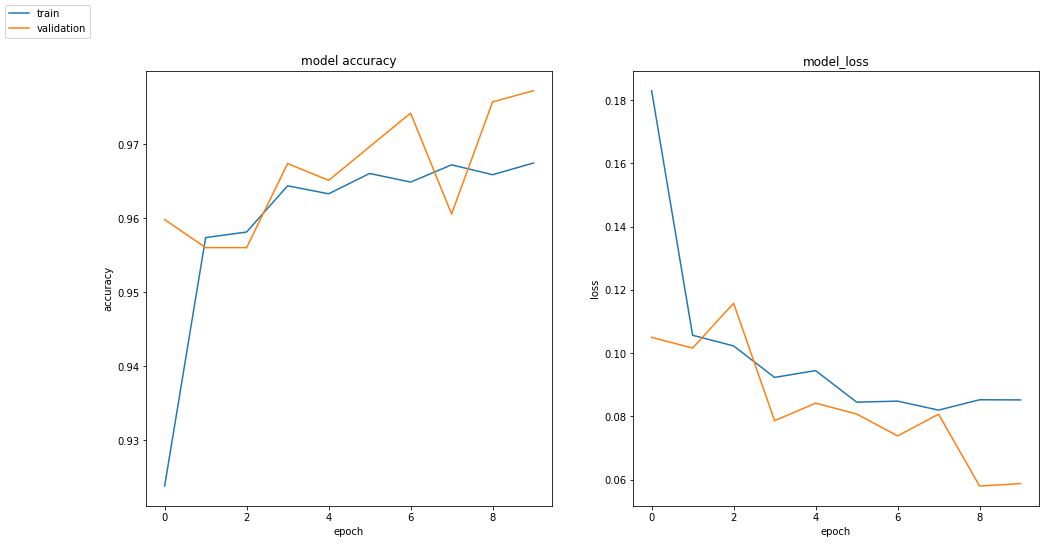

In [11]:
# plot out train vs validation's loss and accuracy
def plot_hist(hist):
    fig = plt.figure(figsize=(16,8))
    
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    
    ax1.plot(hist.history["accuracy"])
    ax1.plot(hist.history["val_accuracy"])
    ax1.set_title("model accuracy")
    ax1.set_ylabel("accuracy")
    ax1.set_xlabel("epoch")
    
    ax2.plot(hist.history["loss"])
    ax2.plot(hist.history["val_loss"])
    ax2.set_title("model_loss")
    ax2.set_ylabel("loss")
    ax2.set_xlabel("epoch")
    fig.legend(["train", "validation"], loc="upper left")
    fig.show()
    
plot_hist(history)

In [12]:
# Now, Update weight parameter
for layer in model.layers:
    layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=0.01)
model.compile(loss="binary_crossentropy", optimizer=optimizer, 
              metrics = ["accuracy"])
history = model.fit(train_set,
                   steps_per_epoch=int(0.75 * 16000 / train_batch),
                   validation_data=val_set,
                   validation_steps=int(0.15 * 9000 / val_batch),
                   epochs=15, callbacks=EarlyStopping(monitor="val_loss", 
                                                      mode="min", verbose=1, patience=5))


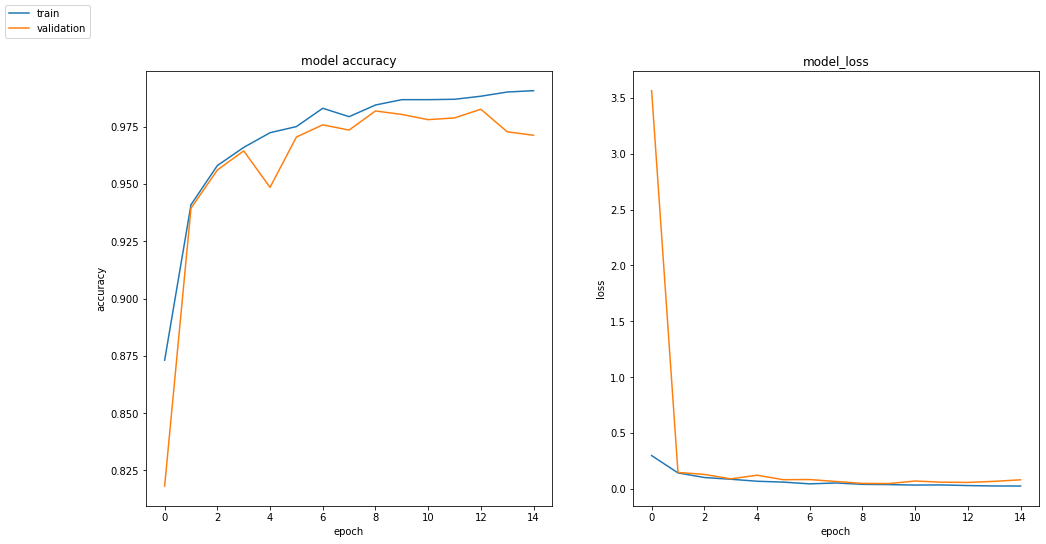

In [27]:
# plot out train vs validation's loss and accuracy
def plot_hist(hist):
    fig = plt.figure(figsize=(16,8))
    
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    
    ax1.plot(hist.history["accuracy"])
    ax1.plot(hist.history["val_accuracy"])
    ax1.set_title("model accuracy")
    ax1.set_ylabel("accuracy")
    ax1.set_xlabel("epoch")
    
    ax2.plot(hist.history["loss"])
    ax2.plot(hist.history["val_loss"])
    ax2.set_title("model_loss")
    ax2.set_ylabel("loss")
    ax2.set_xlabel("epoch")
    fig.legend(["train", "validation"], loc="upper left")
    fig.show()
    
plot_hist(history)

2. VGG16

In [13]:
# customize own model structure by doing transfer learning with pretrained model: ResNet50V2
# 1. Instantiate a base model 
vgg = VGG16(input_shape = input_shape, weights = 'imagenet',include_top = False)

# 2. Fix the pre-trained model layer and only modify the last layer
for layer in vgg.layers:
    layer.trainable = False
    
# rebuild the model with pre-trained model 
model2 = Sequential()
model2.add(vgg)
model2.add(layers.GlobalAveragePooling2D(name="avg"))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(DROPOUT_RATE, name="dropout"))
model2.add(layers.Dense(1, activation = 'sigmoid'))

58900480/58889256 [==============================] - 0s 0us/step


In [14]:
# set up optimizer and what loss function to use
optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=0.01)
model2.compile(loss="binary_crossentropy", optimizer=optimizer, metrics = ["accuracy"])

# model training
history2 = model2.fit(train_set,
                   steps_per_epoch=int(0.75 * 16000 / train_batch),
                   validation_data=val_set,
                   validation_steps=int(0.15 * 9000 / val_batch),
                   epochs=10, callbacks=EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5))

Epoch 1/10
120/120 [==============================] - 195s 2s/step - loss: 0.5768 - accuracy: 0.7023 - val_loss: 0.6254 - val_accuracy: 0.5659
Epoch 2/10
120/120 [==============================] - 183s 2s/step - loss: 0.4255 - accuracy: 0.8061 - val_loss: 0.5339 - val_accuracy: 0.7879
Epoch 3/10
120/120 [==============================] - 183s 2s/step - loss: 0.3950 - accuracy: 0.8207 - val_loss: 0.4431 - val_accuracy: 0.8379
Epoch 4/10
120/120 [==============================] - 184s 2s/step - loss: 0.3763 - accuracy: 0.8349 - val_loss: 0.3910 - val_accuracy: 0.8417
Epoch 5/10
120/120 [==============================] - 190s 2s/step - loss: 0.3710 - accuracy: 0.8303 - val_loss: 0.3506 - val_accuracy: 0.8606
Epoch 6/10
120/120 [==============================] - 188s 2s/step - loss: 0.3534 - accuracy: 0.8455 - val_loss: 0.3346 - val_accuracy: 0.8598
Epoch 7/10
120/120 [==============================] - 184s 2s/step - loss: 0.3488 - accuracy: 0.8446 - val_loss: 0.3145 - val_accuracy: 0.8598

In [17]:
# model summary
for index, layer in enumerate(model2.layers):
    print(index, layer.name)

0 vgg16
1 avg
2 batch_normalization_2
3 dropout
4 dense_2


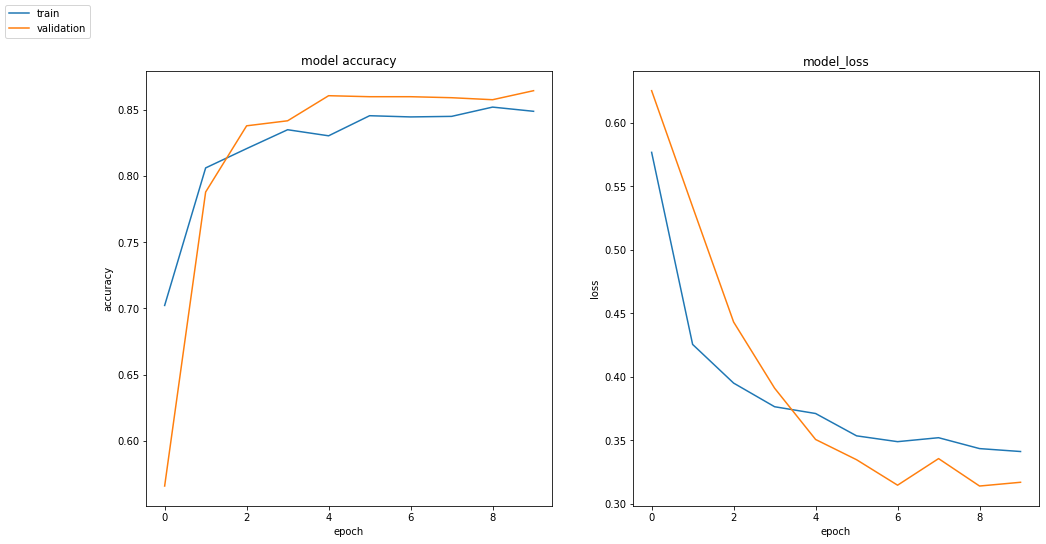

In [18]:
# plot out train vs validation's loss and accuracy
def plot_hist(hist):
    fig = plt.figure(figsize=(16,8))
    
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    
    ax1.plot(hist.history["accuracy"])
    ax1.plot(hist.history["val_accuracy"])
    ax1.set_title("model accuracy")
    ax1.set_ylabel("accuracy")
    ax1.set_xlabel("epoch")
    
    ax2.plot(hist.history["loss"])
    ax2.plot(hist.history["val_loss"])
    ax2.set_title("model_loss")
    ax2.set_ylabel("loss")
    ax2.set_xlabel("epoch")
    fig.legend(["train", "validation"], loc="upper left")
    fig.show()
    
plot_hist(history2)

#### Make Prediction

In [24]:
# make prediction for RESNET50V2
pred1 = model1.predict(test_set, verbose = 1)
pred1 = pd.DataFrame(pred1)
pred1

# set up the submission
resnet_results = pd.DataFrame(
    {'id': pd.Series(test_set.filenames), 
     'label': pred1[0].round(6)})

resnet_results['id'] = resnet_results.id.str.extract('(\d+)')
resnet_results['id'] = pd.to_numeric(resnet_results['id'], errors = 'coerce')
resnet_results.sort_values(by='id', inplace = True)

resnet_results.to_csv('submission.csv', index=False)
resnet_results.head()

391/391 [==============================] - 44s 110ms/step


,id,label
0,1,0.997546
3612,2,0.999996
4723,3,0.999994
5834,4,0.998620
6945,5,0.000821


In [23]:
# make prediction for VGG16
pred2 = model2.predict(test_set, verbose = 1)
pred2 = pd.DataFrame(pred2)
pred2

# set up the submission
vgg_results = pd.DataFrame(
    {'id': pd.Series(test_set.filenames), 
     'label': pred2[0].round(6)})

vgg_results['id'] = vgg_results.id.str.extract('(\d+)')
vgg_results['id'] = pd.to_numeric(vgg_results['id'], errors = 'coerce')
vgg_results.sort_values(by='id', inplace = True)

vgg_results.to_csv('submission.csv', index=False)
vgg_results.head()

391/391 [==============================] - 44s 104ms/step


,id,label
0,1,0.962004
3612,2,0.999704
4723,3,0.998818
5834,4,0.990710
6945,5,0.018489


#### Reference
[Transfer Learning by Dan B](/https://www.kaggle.com/code/dansbecker/transfer-learning/notebook)

[Tutorial Keras: Transfer Learning with ResNet50](/https://www.kaggle.com/code/suniliitb96/tutorial-keras-transfer-learning-with-resnet50)

[Cats vs Dogs:- Basic CNN tutoriaL](/https://www.kaggle.com/code/ruchibahl18/cats-vs-dogs-basic-cnn-tutorial/notebook)

https://stackoverflow.com/questions/71827495/how-to-properly-use-pre-trained-cnn-for-image-prediction-on-a-folder-of-images